In [1]:
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines


In [2]:
#-------------------------------------------------------
#                    (i-1,j)
#                       |
#                       |
#                       |
#                       |
# (i,j-i)-------------(i,j)------------- (i,j+1)
#                       |
#                       |
#                       |
#                       |
#                    (i+1,j)
#-------------------------------------------------------

### Growth Rate (GR) Equation

The equation for the growth rate (GR) in nm/min is:

$$
GR = \left( 8P + n_n^2 \frac{T - 273.15}{10} \right) \left( 2n_b^2 \times 10^6 \right) e^{\frac{-1.39 \, eV}{k_B T}}
$$

#### Definitions

- ${P}$: Partial Pressure of the gas in Pa (ex, 133 Pa = 1 torr)
- ${n_n}$: Number of neighbors in the current layer
- ${n_b}$: Number of bonds available 
- ${T}$: Temperature in Kelvin (ex, 500 C)
- ${k_B}$: Boltzmann constant in eV 

This means:
- If temperature constant: Scale <b>linearly</b> with partial pressure
- If Pressure constant: Scale <b>exponentially</b> with temperature
- If Neighbours are present: Scale <b>linearly</b> with temperature and <b>exponentially</b> with neighbours
- If Number of bonds present: Scale <b>exponentially</b> with scaling factor of 1 million




In [3]:
kb = 8.6173303 * (10E-5) # eV

def c_to_k(temp):
    return temp + 273.15

def growth_rate(P, nn, nb, T, kb):
    """
    Parameters:
    - P (float): Partial Pressure of the gas (Pa)
    - n_n (int): Number of neighbors in the current layer
    - n_b (int): Number of bonds available
    - T (float): Temperature (K)
    - k_B (float): Boltzmann constant in eV

    Returns:
    - float: growth rate in nm/second
    """

    # Calculate the pressure and temperature dependent linear portion
    linear = 8 * P + (nn ** 2) * ((T - 273.15) / 10 ** 1)

    # Calculate the exponential in the arrhenius equation with scaling factor
    exponential = 4 * nb ** 2  * np.exp(-(1.39) / (kb*T)) * 10 ** 6

    return (linear * exponential) / 60

Text(0.5, 1.02, 'Growth Rate $\\mathbf{(per\\ Atom)}$ vs Growth Parameters')

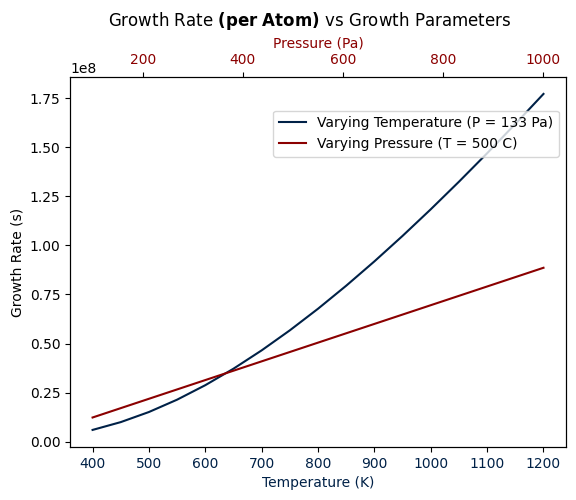

In [5]:
temperatures = list(range(400, 1201, 50)) # C
pressures = list(range(100, 1001, 50)) # Pa

rates_pressure = []
rates_temperature = []

nn, nb = 4, 2 # Max value for each growth rate input
for P in pressures:
    rate = growth_rate(P, nn, nb, 500, kb)  
    rates_pressure.append(rate)

for T in temperatures:
    rate = growth_rate(133, nn, nb, T, kb) 
    rates_temperature.append(rate)

fig, ax1 = plt.subplots()

# Plot data on the first axis 
ax1.plot(temperatures, rates_temperature, color='#002147', label='Varying Temperature (P = 133 Pa)')
ax1.set_xlabel('Temperature (K)', color='#002147')
ax1.set_ylabel('Growth Rate (s)') #, color='b')
ax1.tick_params(axis='x', labelcolor='#002147')

# Create a second x-axis
ax2 = ax1.twiny()
ax2.plot(pressures, rates_pressure, color='#8B0000', label='Varying Pressure (T = 500 C)')
ax2.set_xlabel('Pressure (Pa)', color='#8B0000')
ax2.tick_params(axis='x', labelcolor='#8B0000')

# Add a legend
fig.legend(loc='lower right', bbox_to_anchor=(0.9, 0.7))
fig.suptitle('Growth Rate ' + r'$\mathbf{(per\ Atom)}$' + ' vs Growth Parameters', y=1.02)


### Grain growth:
There are 4 different distinct layers. The initial substrate will start following a type 1 layer.

Layers are grown as follows:

|        |  
|--------|  
| Repeat Types 1-4 Growth <br>.<br>.<br>. |  
| Type 4 |  
| Type 3 |  
| Type 2 |  
| Type 1 |  

<br>


### Layer Types:
* Type 1: Layer % 4 == 1 
* Type 2: Layer % 4 == 2
* Type 3: Layer % 4 == 3
* Type 4: Layer % 4 == 4

The available locations of atoms can be seen in the generated graph called _Layers_

In [38]:
def initialize_lattice(size, layer_number=1, percentage=1, seed=None):
    """
    Initialize a 2D lattice grid with the specified size and for a layer.
    
    Parameters:
    - size (int): The size of the lattice (NxN).                  
                  Should be a multiple of 4 in order for the lattice to be periodic.
    - layer_number (int): The layer number a new lattice is being generated for. 
    - percentage (float): Fraction of sites to initialize with a value of 1. Must be between 0 and 1.
                            -> Current code needs to be updated for this function to work
    - seed (int or None): Seed for the random number generator for reproducibility. Default is None.
    
    Returns:
    - np.ndarray: Initialized lattice with specified occupancy.
    """
    if size % 4 != 0:
        raise ValueError('Size of lattice must be multiple of 4 to maintain periodicity.')
    
    if not (0 <= percentage <= 1):
        raise ValueError('Percentage must be between 0 and 1.')

    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # Create an NxN lattice filled with zeros
    lattice = np.zeros((size, size), dtype=int)

    if layer_number % 4 == 1:
        # Type 1
        atom_locations = np.array([
            [1, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 0]
        ])
    elif layer_number % 4 == 2:
        # Type 2
        atom_locations = np.array([
            [0, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1]
        ])
    elif layer_number % 4 == 3:
        # Type 3
        atom_locations = np.array([
            [0, 0, 1, 0],
            [0, 0, 0, 0],
            [1, 0, 0, 0],
            [0, 0, 0, 0]
        ])      
    else:
        # Type 4
        atom_locations = np.array([
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],
            [0, 1, 0, 0]
        ]) 
        
    rows, cols = atom_locations.shape
    lattice = np.tile(atom_locations, (size // rows, size // cols))

    return lattice

def get_array_of_sites(size, layer_number):
    """
    Generate an array of site indices for the lattice.
    
    The sites indices will be for every other index of the array (layer dependant)
    - Odd layer: sites start at [0, 0]
    - Even layer: sites start at [0, 1]

    Parameters:
    - size (int): The size of the lattice (NxN).
    - layer_number (int): The layer number a new lattice is being generated for.

    Returns:
    - list( tuple(int, int) ): Array of layer depedant site indices.
    """
    # Generate mask containing 1s at the sites
    layer_mask = initialize_lattice(size, layer_number)

    array_of_sites = []

    for i in range(size):
        for j in range(size):
            if layer_mask[(i, j)]:
                array_of_sites.append((i, j))
                
    return array_of_sites

### Graph of Layer Grain Growth

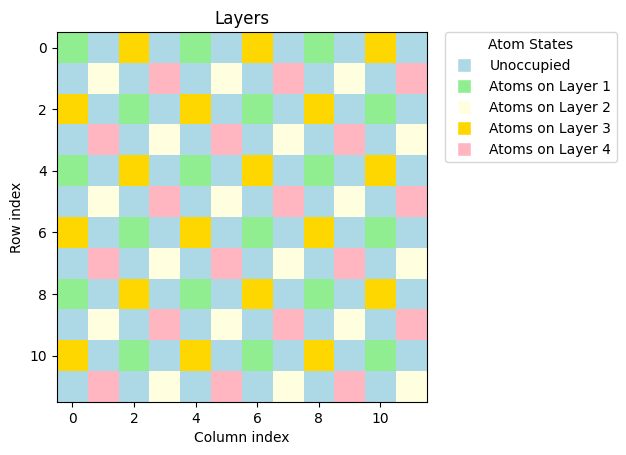

In [39]:
type1, type2, type3, type4 = initialize_lattice(12, 1), initialize_lattice(12, 2), initialize_lattice(12, 3), initialize_lattice(12, 4)
type2[type2 == 1] = 2
type3[type3 == 1] = 3
type4[type4 == 1] = 4

all_layers = type1 + type2 + type3 + type4

# Define custom colors for each value in the matrix
cmap = mcolors.ListedColormap(['#ADD8E6', '#90EE90', '#FFFFE0', '#FFD700', '#FFB6C1'])  # Light blue, light green, light yellow, light orange, light red

# Create the heatmap
plt.imshow(all_layers, cmap=cmap, interpolation='nearest')

# Define labels for each color in the matrix
labels = ['Unoccupied', 'Atoms on Layer 1', 'Atoms on Layer 2', 'Atoms on Layer 3', 'Atoms on Layer 4']

# Create custom proxy artists for each label
proxy_elements = [mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(5)]

# Add the legend
plt.legend(proxy_elements, labels, loc='upper left', title="Atom States", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Adjust the layout to make room for the legend outside the graph
plt.subplots_adjust(right=0.8)

# Add labels and title
plt.title('Layers')
plt.xlabel('Column index')
plt.ylabel('Row index')

# Show the plot
plt.show()


In [40]:
def coordinates_neighbours(site_coordinate, length, layer='current'):
    '''
    Calculates coordinates of neighbouring atoms on the current or previous layer, in the form:
    [NE, SE, SW, NW]

    Say the atom below (1) is the input site coordinate. The * represent the [NE, SE, SW, NW]
    coordinates this function is locating.
    
    CURRENT LAYER:
          N
      * 0 0 0 * 
      0 0 0 0 0
    W 0 0 1 0 0 E
      0 0 0 0 0 
      * 0 0 0 *
          S
    
    PREVIOUS LAYER:
        N
      * 0 * 
    W 0 1 0 E
      * 0 *
        S

    Parameters:
    - site_coordinates (tuple(int, int)): Coordinates of the site on the current layer.
    - length (int): The size of the lattice (NxN).
    - layer (str): 'current' for the function to retrieve coordinates of neighbours on the current layer
                   'previous' for the function to retrieve coordinates of neighbours on the previous layer

    Returns:
    - list( tuple(int, int) ): Array of coordinates for neighbours in the current layer.
                                -> [NE, SE, SW, NW]
    '''
    # Determine the neighboring coordinates for a given site
    x, y = site_coordinate
    
    if layer == 'current':
        neighbours = [
            ((x - 2) % length, (y + 2) % length),  # NE neighbor
            ((x + 2) % length, (y + 2) % length),  # SE neighbor
            ((x + 2) % length, (y - 2) % length),  # SW neighbor
            ((x - 2) % length, (y - 2) % length)   # NW neighbor
        ]
    elif layer == 'previous':
        neighbours = [
            ((x - 1) % length, (y + 1) % length),  # NE neighbor
            ((x + 1) % length, (y + 1) % length),  # SE neighbor
            ((x + 1) % length, (y - 1) % length),  # SW neighbor
            ((x - 1) % length, (y - 1) % length)   # NW neighbor
        ]   

    return neighbours

In [41]:
def get_number_neighbours(current_layer, previous_layer, site_coordinate, length):
    '''
    Calculates the number of neighbours on the previous layer and current layer, and determines if bonding 
    is possible at the site coordinate.

    Parameters:
    - current_layer (np.array): Lattice layer (2D, NxN) that is current being grown.
    - previous_layer (np.array): Lattice layer (2D, NxN) that atoms on current layer are being bonded to.
    - site_coordinates (tuple(int, int)): Coordinates of the site on the current layer.
    - length (int): The size of the lattice (NxN).

    Returns:
    - int, int, int: -> number_neighbours_previous_layer: for the given site coordinate 
                                                            - also corresponds to a number of bonds for a given layer
                      -> number_neighbours_current_layer: for the given site coordinate
    '''
    # Count the number of occupied neighbors for a given site for the current and previous layer
    number_neighbours_previous_layer = 0
    number_neighbours_current_layer = 0
    
    # Returns [NE, SE, SW, NW]
    neighbours_previous_layer = coordinates_neighbours(site_coordinate, length, 'previous')
    
    # Returns [NE, SE, SW, NW]
    neighbours_current_layer = coordinates_neighbours(site_coordinate, length, 'current') 

    # Get number of neighbours on previous layer -> this is equal the number of bonds an atom can form
    for neighbour in neighbours_previous_layer:
        number_neighbours_previous_layer += previous_layer[neighbour]

    # Get number of neighbours on current layer
    for neighbour in neighbours_current_layer:
        number_neighbours_current_layer += current_layer[neighbour]

    return number_neighbours_previous_layer, number_neighbours_current_layer


In [42]:
def step_forward(current_time, current_layer, layer_number, previous_layer, array_of_sites, length, simulation_params=(133, 500)):
    """
    Perform a single time step in the simulation, where based on probabilities, an atom will bond to 
    the current layer.
    
    Parameters:
    - current_time (float): Current simulation time
    - current_layer (np.array): Lattice layer (2D, NxN) that is current being grown.
    - layer_number (int): Layer number of current layer.
    - previous_layer (np.array): Lattice layer (2D, NxN) that atoms on current layer are being bonded to.
    - array_of_sites (list( tuple(int, int) )): List of site indices in the lattice
    - length (int): The size of the lattice (NxN).
    - simulation_params (tuple): Tuple containing (partial_pressure in Pa, temperature in C)
    
    Returns:
    - np.array, float: Updated current_layer array and new time
    """
    partial_pressure, temperature = simulation_params # [s^-1]

    # Convert temp to K
    temperature = c_to_k(temperature)

    # Calculate rates based on if bonding is possible, and neighbours in previous and current layers
    rates = np.zeros(len(array_of_sites))

    for site_index, site_coordinate in enumerate(array_of_sites):
        number_neighbours_previous_layer, number_neighbours_current_layer = get_number_neighbours(current_layer, previous_layer, site_coordinate, length)

        # If site is unoccupied and bonding is possible
        if current_layer[site_coordinate] == 0 and number_neighbours_previous_layer:
            rates[site_index] = growth_rate(partial_pressure, number_neighbours_current_layer, number_neighbours_previous_layer, temperature, kb)
        else:
            rates[site_index] = 0

    # Calculate total rate
    total_rate = np.sum(rates)

    # Select a random site to update based on calculated rate if there are non zero probabilities
    if total_rate != 0:
        chosen_site_index = np.random.choice(len(array_of_sites), p=rates / total_rate)
        chosen_site = array_of_sites[chosen_site_index]

        # Atom bonded!
        current_layer[chosen_site] = 1

    # Randomly step time forward by exponential distribution
    current_time += np.random.exponential(1 / total_rate)
    return current_layer, current_time

In [43]:
def run_monolayer_simulation(current_layer, layer_number, previous_layer, length, n_steps=100, simulation_params=(133,500)):
    """
    Perform a simulation for monolayer growth, and save the times, lattice configurations, and fractional coverage.
    
    Parameters:
    - current_layer (np.array): Lattice layer (2D, NxN) that is current being grown.
    - layer_number (int): Layer number of current layer.
    - previous_layer (np.array): Lattice layer (2D, NxN) that atoms on current layer are being bonded to.
    - length (int): The size of the lattice (NxN).
    - n_steps (int): The number of steps to run the simulation over.
    - simulation_params (tuple): Tuple containing (partial_pressure in Pa, temperature in C)
    
    Returns:
    - list(np.array): List of lattice layer (2D, NxN) for each simulation step
    - list(float): List of times for each simulation step
    - list(float): List of fractional coverage of lattice layer for each simulation step
    """
    current_time = 0

    # Initialize lists for keeping track of configurations, times, and fractional coverage
    configurations = [current_layer.copy()]
    times = [0]
    fractional_coverages = [np.sum(current_layer) * 8 / (length ** 2) ]

    array_of_sites = get_array_of_sites(length, layer_number)
    for _ in range(n_steps):
        current_layer, current_time = step_forward(current_time, current_layer, layer_number, previous_layer, array_of_sites, length, simulation_params)
        
        # Save current lattice, time, and fractional coverage
        configurations.append(current_layer.copy()) 
        times.append(current_time) 
        fractional_coverages.append(np.sum(current_layer) * 8 / (length ** 2))
    
    return configurations, times, fractional_coverages


In [44]:
def grow_Si(layers, length, percent_occupied_substrate=1, n_steps=100, simulation_params=(133,500), return_configurations=False):
    """
    Perform a simulation for silicon growth.
    
    Parameters:
    - layers (int): Number of total Si layers
                    -> The first layer is the substrate, so if layers = 5, then 4 additional monolayers will be grown
                       to have a total of 5 layers
    - length (int): The size of the lattice (NxN).
    - percent_occupied_substrate: Fraction of sites to initialize with a value of 1. Must be between 0 and 1.  
    - n_steps (int): The number of steps to run the simulation over.
    - simulation_params (tuple): Tuple containing (partial_pressure in Pa, temperature in C)
    - reuturn_configurations (bool): Set to True to return all configurations for each monolayer and their corresponding times
    
    Returns:
    - list(np.array): List of final lattice layers (2D, NxN) for each monolayer growth
    - list(float): List of all time step when monolayer growth is completed
    - list(dictionary): If return_configurations is set to True, for each monolayer:
                        {
                            configurations: List of lattice layer (2D, NxN) for each simulation step,
                            times: List of times for each simulation step
                        }
    """
    empty_template = np.zeros((length,length),dtype=int) # initialize_lattice(length, 2, 0)
    previous_layer = initialize_lattice(length, 1, percent_occupied_substrate) # initial substrate layer

    # saved layers
    output_layers = [previous_layer.copy()]
    output_times = [0]
    monolayer_configurations = [
        {
            'configurations': [previous_layer.copy()],
            'times': [0]
        }
    ]

    # start growth on second layer
    for layer in range(2, layers+1):
        current_layer = empty_template.copy()
        configurations, times, fractional_coverages = run_monolayer_simulation(current_layer, layer, previous_layer, length, n_steps, simulation_params)
        previous_layer = configurations[-1]
        output_layers.append(previous_layer.copy())
        output_times.append(sum(times))

        if return_configurations:
            monolayer_configurations.append(
                {
                    'configurations': configurations.copy(),
                    'times': times.copy()
                }
            )

    output = (output_layers, output_times, monolayer_configurations) if return_configurations else (output_layers, output_times)
    
    return output

# layers = grow_Si(10, LENGTH, 1, 190)


### Example Monolayer Growth

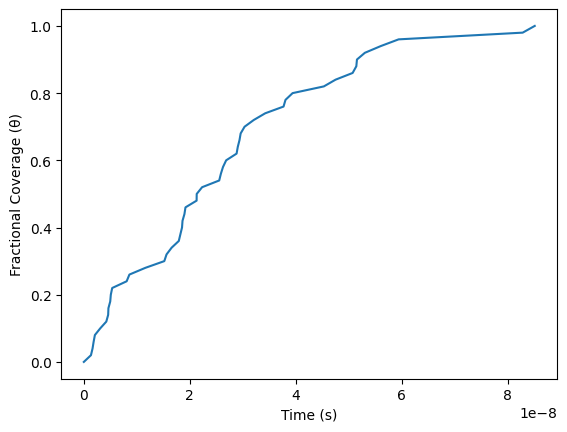

In [11]:
LENGTH = 20
base_Si_layer = initialize_lattice(LENGTH, 1) # 0.90 contains 10% vacancies (defects)

# even, layer 2
second_layer = np.zeros((LENGTH, LENGTH), dtype=int) # initialize_lattice(LENGTH, 2, 0) # Say majority of it is empty

configurations, times, fractional_coverages = run_monolayer_simulation(second_layer, 2, base_Si_layer, LENGTH, n_steps=50, simulation_params=(133, 500))

plt.plot(times, fractional_coverages)
plt.xlabel('Time (s)'), plt.ylabel('Fractional Coverage (θ)')
plt.show()

# unit is nm/s

In [12]:
layer_mask = initialize_lattice(LENGTH, 1)
base_Si_layer[(base_Si_layer == 0) & (layer_mask != 0)] = 2

base_Si_layer[base_Si_layer == 1] = 3
for i, config in enumerate(configurations):
    configurations[i] = np.abs(base_Si_layer - config)

In [13]:
# Create the figure
fig = go.Figure()

# Add traces for the first configuration (initial frame)
fig.add_trace(go.Heatmap(
    z=configurations[0],
    colorscale=[
        [0, 'blue'],     # 0 -> unoccupied on current layer
        [0.33, 'red'],   # 1 -> occupied on current layer
        [0.67, 'green'], # 2 -> unoccupied on previous layer
        [1.0, 'yellow']  # 3 -> occupied on previous layer
    ],
    colorbar= dict(
        title="Legend",  # Title for the legend
        titleside="bottom",
        tickvals=[0, 1, 2, 3],  # Values for the ticks
        ticktext=["unoccupied on current layer", "occupied on current layer", "unoccupied on previous layer", "occupied on previous layer"]  # Labels for the ticks
    ),
    showscale=True,
    zmin=0,
    zmax=3
))

# Define frames for the animation
frames = [
    go.Frame(
        data=[go.Heatmap(
            z=config,
            colorscale=[
                [0, 'blue'],   # 0
                [0.33, 'red'],   # 1
                [0.67, 'green'], # 2
                [1.0, 'yellow']  # 3
            ],
            showscale=True,
            zmin=0,
            zmax=3
        )],
        name=f"Step {step}"
    )
    for step, config in enumerate(configurations)
]

fig.frames = frames

# Add buttons and slider for animation
fig.update_layout(
    title='Adsorption Process Animation',
    xaxis_title='Lattice X',
    yaxis_title='Lattice Y',
    height=600,
    width=800,
    showlegend=True,  # Make sure the legend is shown in every frame
    legend=dict(
        x=1.05,   # Position of legend on x-axis
        y=0.5,    # Position of legend on y-axis
        traceorder='normal',
        font=dict(size=10),  # Adjust font size for smaller legend
        bgcolor='rgba(255, 255, 255, 0)',  # Optional: transparent background
        bordercolor='Black',
        borderwidth=1
    ),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Time Step: ',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [{
            'args': [[f"Step {step}"], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
            'label': str(step),
            'method': 'animate'
        } for step in range(len(configurations))]
    }]
)

# Show the figure
fig.show()

### Example Si Lattice Growth

In [49]:
LENGTH = 16 

# 32 step swill saturate each atom layer; set steps = 28 to have 4 vacancies per layer
layers, times = grow_Si(5, LENGTH, 1, 28) 

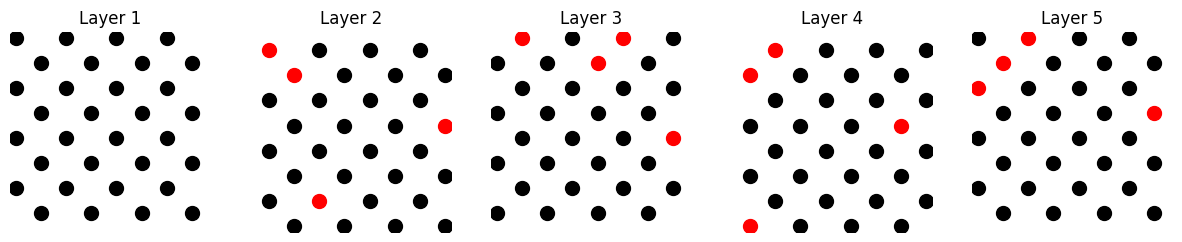

<Figure size 1500x400 with 0 Axes>

In [149]:
array_list = layers.copy()

for i, layer in enumerate(array_list):
    mask = initialize_lattice(LENGTH, i+1)
    layer[(layer == 0) & (mask != 0)] = 2
    array_list[i] = layer

# Determine number of rows and columns needed
max_columns = 5
num_arrays = len(array_list)
num_rows = (num_arrays // max_columns) + (num_arrays % max_columns > 0)

# Create the subplots
fig, axes = plt.subplots(num_rows, max_columns, figsize=(15, num_rows * 3))

# Create a gridspec with increased spacing
fig = plt.figure(figsize=(15, num_rows * 4))
gs = fig.add_gridspec(num_rows, max_columns, hspace=0.5)  # Adjust `hspace` for row spacing

# Flatten axes array for easy iteration, in case we have a 2D grid of subplots
axes = axes.flatten()

# Plot each binary array
for i, array in enumerate(array_list):
    # Get the indices of the 1's in the array
    ones = np.column_stack(np.where(array == 1))
    twos = np.column_stack(np.where(array == 2))

    # Scatter plot for the 1's, using dots
    axes[i].scatter(ones[:, 1], ones[:, 0], color='black', s=100, marker='o')
    axes[i].scatter(twos[:, 1], twos[:, 0], color='red', s=100, marker='o')
    axes[i].set_title(f"Layer {i+1}")
    axes[i].set_xlim(-0.5, array.shape[1]-0.5)
    axes[i].set_ylim(array.shape[0]-0.5, -0.5)
    axes[i].set_aspect('equal')  # Make sure the grid is square
    axes[i].axis('off')  # Turn off the axis

# Turn off axes for any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout to avoid overlap
plt.show()

### Converting to LAMMPS and OVITO output <br>

#### Scaling factor of atoms position for Si lattice:
* Distance between neighbours is 0.235 nm diagonally
* Distance in x, y, and z are offset by 1/4 times the lattice constant (where &alpha; / 4 = 0.13575 nm):

<div align="center">

$$
\vec{r}_1 = \frac{\alpha}{4} \vec{x} + \frac{\alpha}{4} \vec{y} + \frac{\alpha}{4} \vec{z}
$$

</div>

* Si radius is 0.132 nm

In [ ]:
alpha = 5.43 # A
offset = alpha/4 
radius = 1.32 # A

# Generating trajectory file of growth over time for OVITO, and input structure file for lammps

with open('silicon.lammpstrj', 'w') as file: # monolayer by monolayer visualization 
    total_layers = len(layers) 
    
    sum_atoms = 0
    atom_id = 1
    atom_data = ''
    bounds = [(0.0, offset * LENGTH), (0.0, offset * LENGTH), (0.0, offset * total_layers)]

    for z, layer in enumerate(layers):
        file.write('ITEM: TIMESTEP\n')
        file.write(f'{sum(times[0:z+1])}\n')

        sum_atoms += np.sum(layer)
        file.write('ITEM: NUMBER OF ATOMS\n')
        file.write(f'{sum_atoms}\n')

        file.write('ITEM: BOX BOUNDS pp pp pp\n')
        
        for bound in bounds:
            file.write(f'{bound[0]} {bound[1]}\n')

        file.write('ITEM: ATOMS id type x y z\n')
        if atom_data:
            file.write(atom_data)

        for x in range(LENGTH):
            for y in range(LENGTH):
                if layer[x,y]:

                    info = (atom_id, 1, (x * offset), (y * offset), (z * offset))
                    info_str = ' '.join(map(str, info)) + '\n'
                    atom_data += info_str
                    file.write(info_str)
                    atom_id += 1


with open('silicon.data', 'w') as file:
    file.write('# Header \n')
    file.write(f'{sum_atoms} atoms\n\n')
    file.write('   1 atom types\n\n')
    
    bounds = [(0.0, LENGTH * offset, 'xlo xhi'), (0.0, LENGTH * offset, 'ylo yhi'), (0.0, total_layers * offset, 'zlo zhi')]

    for bound in bounds:
        file.write(f'{bound[0]} {bound[1]} {bound[2]}\n')

    file.write('0.000000 0.000000 0.000000 xy xz yz\n\n')

    file.write('Masses\n\n1 28.0855\n\n')
    
    file.write('Atoms\n\n')
    file.write(atom_data) 

    file.write('\n')

#### LAMMPS trajectory file for atom by atom growth

In [ ]:
LENGTH = 8
layers, times, configurations = grow_Si(4, LENGTH, 1, 8, return_configurations=True)

In [ ]:
with open('silicon_atom_by_atom.lammpstrj', 'w') as file: # atom by atom visualization    
    total_layers = len(layers) 
    
    sum_atoms = 0
    atom_id = 1
    atom_data = ''
    bounds = [(0.0, offset * LENGTH), (0.0, offset * LENGTH), (0.0, offset * total_layers)]

    timestep = 0

    # do first initial configuration
    file.write('ITEM: TIMESTEP\n')
    file.write(f'{timestep}\n')

    first_config = configurations[0]['configurations'][0]
    sum_atoms += np.sum(first_config)
    file.write('ITEM: NUMBER OF ATOMS\n')
    file.write(f'{sum_atoms}\n')

    file.write('ITEM: BOX BOUNDS pp pp pp\n')

    for bound in bounds:
        file.write(f'{bound[0]} {bound[1]}\n')

    file.write('ITEM: ATOMS id type x y z\n')

    for x in range(LENGTH):
        for y in range(LENGTH):
            if first_config[x,y]:

                info = (atom_id, 1, (x * offset), (y * offset), (0 * offset))
                info_str = ' '.join(map(str, info)) + '\n'
                atom_data += info_str
                file.write(info_str)
                atom_id += 1

    for z, info in enumerate(configurations[1:], start=1):
        # start at second layer
        configs, time = info['configurations'], info['times']
        for i, config in enumerate(configs[1:], start=1):
            # build all atoms of signle monolayer before moving onto next layer, one atom at a time
            timestep += time[i]* (10**8)
            file.write('ITEM: TIMESTEP\n')
            file.write(f'{timestep}\n')

            sum_atoms += np.sum(config)
            file.write('ITEM: NUMBER OF ATOMS\n')
            file.write(f'{sum_atoms}\n')

            file.write('ITEM: BOX BOUNDS pp pp pp\n')
        
            for bound in bounds:
                file.write(f'{bound[0]} {bound[1]}\n')

            file.write('ITEM: ATOMS id type x y z\n')
            if atom_data:
                file.write(atom_data)

            print(z+1)
            for x in range(LENGTH):
                for y in range(LENGTH):
                    if config[x,y]:

                        info = (atom_id, 1, (x * offset), (y * offset), (z * offset))
                        info_str = ' '.join(map(str, info)) + '\n'
                        atom_data += info_str
                        file.write(info_str)
                        atom_id += 1